# Introduction





Dinda Tirta Rahayu

FTDS Batch 004 

---------
# The Problem

### What is Churn?

A churned user is a user who has stopped using an app. There are two kinds of actions a user takes related to churn: either lapsing in use (which means no more sessions being recorded) or uninstalling the app from the device itself. But essentially, churn rate is the number of users that leave your app in a given period of time.



### The Benefit of Measuring Churn

If Telco user churn is high, you could be spending a lot of money on user acquisition but not getting the maximum ROI from the user. By identifying what the issues are, Telco can improve user retention and therefore revenue. 

However, Telco apps should measure churn to ensure that enough users are staying put, hitting the required milestones within Telco apps to remain profitable.

**So, here we try to build churn customer prediction for detecting which customers are likely to leave a service or to cancel a subscription to a service.**

-----------
# Import the Libraries

In [5]:
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
print(tf.__version__)
print(tf.keras.__version__)
from tensorflow import keras

np.set_printoptions(precision=4)

from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

2.7.0
2.7.0


------------------
# Kaggle Installation

In [6]:
# Install Kaggle library in Google Collaboratory.

## Install Kaggle library
!pip install kaggle

## Make a directory named `.kaggle` 
!mkdir ~/.kaggle

## Copy the kaggle.json into this new directory 
!cp kaggle.json ~/.kaggle/

## Change permission for this directory : 
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
# Download dataset

%%time
!kaggle datasets download -d blastchar/telco-customer-churn

telco-customer-churn.zip: Skipping, found more recently modified local copy (use --force to force download)
CPU times: user 13.3 ms, sys: 8.66 ms, total: 21.9 ms
Wall time: 627 ms


In [8]:
# Every dataset that downloaded from Kaggle, is in format `.zip`. So, we must unzip it before we can using the dataset.

!unzip ./telco-customer-churn.zip

Archive:  ./telco-customer-churn.zip
  inflating: WA_Fn-UseC_-Telco-Customer-Churn.csv  


-------------
# Loading Dataset

In [9]:
# Read The Dataset

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [10]:
print(df.shape)
print(df.info())

(7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null

------------
# Splitting Data Earlier

In [11]:
X = df.drop(['Churn'], axis=1)
y = df['Churn']

**To prevent data leakage**, here we split data into data train, data validation and data test.

In [12]:
# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = True, random_state = 8)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2


print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(y_train.shape))
print("y val shape: {}".format(y_test.shape))

X_train shape: (4225, 20)
y_train shape: (4225,)
X_test shape: (1409, 20)
y_test shape: (1409,)
X_val shape: (4225,)
y val shape: (1409,)


----------
# Data Cleaning

In [13]:
print(f'There are {df.isna().any().sum()} columns with missing values in train transaction data.')

There are 0 columns with missing values in train transaction data.


We can see that in the Telco dataset it doesn't contain any missing values.

But something wrong in here. **Total Charges columns has whitespaces instead of NaN.**

In [14]:
X_train.loc[X_train['TotalCharges'] == ' '] # there's a lot of TotalCharges that contains whitespace.

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,
6754,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,


So, here we try to handle it. We want to replace whitespaces into NaN. After that we handle the missing values.

In [15]:
X_train['TotalCharges'] = X_train['TotalCharges'].apply(lambda x: x.strip()).replace('', np.nan)
X_train['TotalCharges'] = X_train['TotalCharges'].astype('float64')

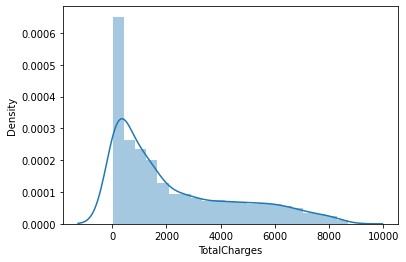

In [16]:
sns.distplot(X_train['TotalCharges'], kde=True, hist=True)

The distribution of Total Charges is right skewed. So, here we impute using Median()

In [17]:
X_train['TotalCharges'] = X_train['TotalCharges'].fillna(X_train['TotalCharges'].median(), axis=0)
X_train['TotalCharges']

608     8306.05
5007     541.50
5329     853.00
3485     131.05
6530    2298.90
         ...   
1265    5264.30
3229    1046.10
3810      44.55
2147     348.80
4252    1033.90
Name: TotalCharges, Length: 4225, dtype: float64

Next step, we are going to convert it into float type.

In [18]:
num_feature = X_train.select_dtypes('number')
num_feature = num_feature.astype('float64')
num_feature

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
608,0.0,72.0,114.55,8306.05
5007,0.0,25.0,20.60,541.50
5329,0.0,25.0,34.00,853.00
3485,0.0,2.0,73.25,131.05
6530,1.0,63.0,36.10,2298.90
...,...,...,...,...
1265,1.0,56.0,94.80,5264.30
3229,0.0,12.0,94.20,1046.10
3810,0.0,1.0,44.55,44.55
2147,0.0,18.0,19.00,348.80


In [19]:
#checking truly distribution of class
print('Distribution of Class No :', y_train[y_train == 'No'].shape[0])
print('Distribution of Class Yes :', y_train[y_train == 'Yes'].shape[0])

Distribution of Class No : 3101
Distribution of Class Yes : 1124


### See the outliers in dataset

In [20]:
#checking outliers using boxplot

box1 = go.Box(y=X_train['SeniorCitizen'], name = 'SeniorCitizen')
box2 = go.Box(y=X_train['tenure'], name = 'tenure')
box3 = go.Box(y=X_train['MonthlyCharges'], name='MonthlyCharges')
box4= go.Box(y=X_train['TotalCharges'], name='TotalCharges')

layout = go.Layout(autosize=False,
                   width = 500,
                   height = 2500
)

data_box = [box1, box2, box3, box4]
fig = go.Figure(data=data_box, layout=layout)
iplot(data_box)

As we can see from above, the dataset has almost **no outliers.**

In [21]:
X_train.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,4225.000000,4225.000000,4225.000000,4225.000000
mean,0.162604,32.357160,64.169053,2258.187669
std,0.369047,24.676362,30.235415,2259.861783
min,0.000000,0.000000,18.250000,18.850000
25%,0.000000,8.000000,34.000000,383.650000
50%,0.000000,29.000000,69.900000,1375.600000
75%,0.000000,56.000000,89.800000,3741.850000
max,1.000000,72.000000,118.650000,8684.800000


In [22]:
#mode values
for i in X_train.select_dtypes('number'):
    print(f'{i}', "mode is", X_train[i].mode()[0])

SeniorCitizen mode is 0
tenure mode is 1
MonthlyCharges mode is 19.85
TotalCharges mode is 20.2


### Summary

1. The tenure column has a mean > mode, this indicates that the tenure column has a right skewed distribution.

2. Monthly Charges and Total Charges columns have a mean > mode, this indicates that these two columns have a right skewed distribution.

In [23]:
y_train_ = pd.DataFrame(y_train)
y_train_

,Churn
608,No
5007,No
5329,Yes
3485,Yes
6530,No
...,...
1265,No
3229,Yes
3810,No
2147,No


--------------------
# Data *Exploration*

### Treat Numerical Features

In [24]:
#encode the label 
rename = {
    "No" : 0,
    "Yes" : 1
}

y_train = y_train.replace(rename)
y_val = y_val.replace(rename)
y_test = y_test.replace(rename)

In [25]:
y_train_num = pd.DataFrame(y_train)
y_train_num

,Churn
608,0
5007,0
5329,1
3485,1
6530,0
...,...
1265,0
3229,1
3810,0
2147,0


In [26]:
train_set = X_train.join(y_train_num)

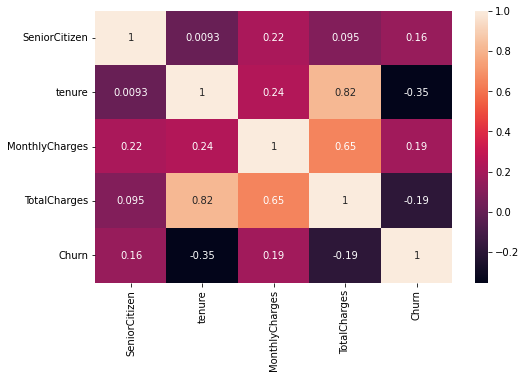

In [27]:
#Pearson corr method to see linear correlation between feature to other feature and feature to label
plt.figure(figsize=(8,5))
sns.heatmap(train_set.corr(method='pearson'), annot=True)
plt.show()

Feature tenure and Total Charges have a negative linear relationship with the target.

In [28]:
#VIF
num_features = train_set.select_dtypes('number').drop(['Churn'],axis=1)
vif_data = pd.DataFrame()
vif_data['feature'] = num_features.columns
vif_data['VIF'] = [variance_inflation_factor(num_features.values, i) for i in range(len(num_features.columns))]
vif_data

,feature,VIF
0,SeniorCitizen,1.257154
1,tenure,6.071484
2,MonthlyCharges,3.695565
3,TotalCharges,7.857121


From above we can see tenure and Total Charges have multicollinearity with other features. But we cannot remove that because the features important enough.

Text(0.5, 1.0, '% of Senior Citizens')

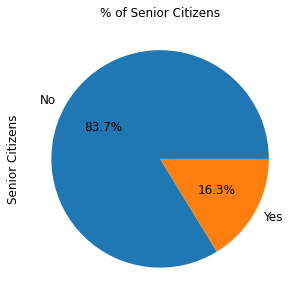

In [29]:
ax = (X_train['SeniorCitizen'].value_counts()*100.0 /len(X_train))\
.plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12)                                                                           
ax.set_ylabel('Senior Citizens',fontsize = 12)
ax.set_title('% of Senior Citizens', fontsize = 12)

We can see from the graph above that currently 16.3% of Telco's customers are old customers who have subscribed while 83.7% are new customers.

Text(0.5, 1.0, '# of Customers by Contract Type')

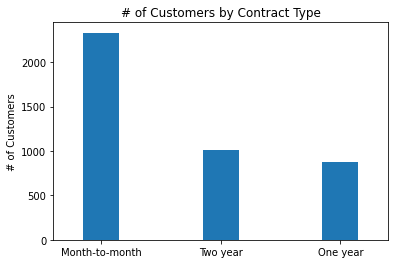

In [30]:
ax = X_train['Contract'].value_counts().plot(kind = 'bar',rot = 0, width = 0.3)
ax.set_ylabel('# of Customers')
ax.set_title('# of Customers by Contract Type')

From the graph above, we can see that the distribution of contracts made by customers to Telco is mostly in the month-to-month type, while the least is in the one year type.

In [31]:
labels = X_train['PaymentMethod'].unique()
values = X_train['PaymentMethod'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(title_text="<b>Payment Method Distribution</b>")
fig.show()

We can see that the payment method that is widely used by customers is Bank Transfer and at least Electronic Check.
The distribution of the bank transfer method is 33.4% while the Electronic Check is 21.5%.

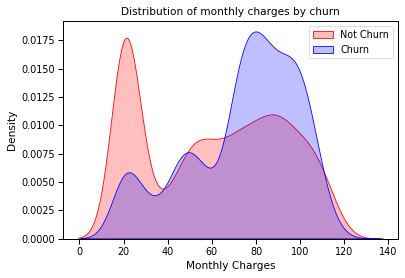

In [32]:
sns.set_context("paper",font_scale=1.1)
ax = sns.kdeplot(X_train.MonthlyCharges[(y_train == 0) ],
                color="Red", shade = True);
ax = sns.kdeplot(X_train.MonthlyCharges[(y_train == 1) ],
                ax =ax, color="Blue", shade= True);
ax.legend(["Not Churn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Monthly Charges');
ax.set_title('Distribution of monthly charges by churn');

Customers with higher Monthly Charges are also more likely to churn.

### Categorical Feature Treatment

In [33]:
# We try to create new columns for just know how the correlation from categorical features

X_test_ = X_test
X_train_ = X_train

X_test_ = X_test_.drop(['MonthlyCharges', 'TotalCharges', 'customerID', 'tenure'], axis=1)
X_train_ = X_train_.drop(['MonthlyCharges', 'TotalCharges', 'customerID', 'tenure'], axis=1)

In [34]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 378 kB/s 


In [35]:
import category_encoders as ce
# Here we creat new column that already encode to plot
OHE = ce.OneHotEncoder(cols=['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],use_cat_names=True)
# encode the categorical variables
train_set = OHE.fit_transform(X_train_)

### 10 features that have a high correlation score chi square.

Feature 14: 222.843854
Feature 15: 172.488651
Feature 16: 259.747420
Feature 17: 172.488651
Feature 19: 157.856966
Feature 20: 172.488651
Feature 22: 155.683984
Feature 23: 172.488651
Feature 25: 243.195428
Feature 26: 172.488651
Feature 29: 172.488651
Feature 32: 172.488651
Feature 34: 319.222466
Feature 35: 103.117447
Feature 36: 311.821549
Feature 41: 239.563006


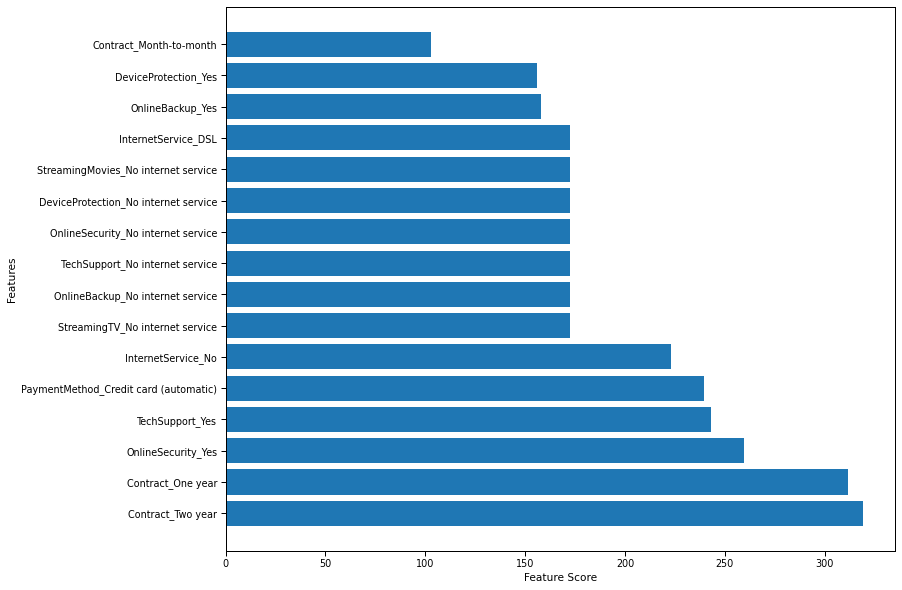

In [36]:
#Categorical Features Correlation
#Create function prepare input to encode the features
def prepare_input(X_train_, X_test_):
  ohe = OneHotEncoder()
  ohe.fit(X_train_)
  X_train_chi = ohe.transform(X_train_)
  X_test_chi = ohe.transform(X_test_)
  return X_train_chi, X_test_chi

#Create function prepare output to encode the target
def prepare_output(y_train, y_test):
  lb = LabelBinarizer()
  lb.fit(y_train)
  y_train_chi = lb.transform(y_train)
  y_test_chi = lb.transform(y_test)
  return y_train_chi, y_test_chi

#Create function feature categorical selection using Chi2 and SelectKBest
def select_features(X_train_, y_train, X_test_):
  fs = SelectKBest(score_func=chi2, k='all')
  fs.fit(X_train_, y_train)
  X_train_fs = fs.transform(X_train_)
  X_test_fs = fs.transform(X_test_)
  return X_train_fs, X_test_fs, fs

#apply function prepare input
X_train_chi, X_test_chi = prepare_input(X_train_, X_test_)
#apply fucntion prepare target
y_train_chi, y_test_chi = prepare_output(y_train, y_test)
# Feature Selection
X_train_fs, X_test_fs, fs = select_features(X_train_chi, y_train_chi, X_test_chi)
# What are scores for the features:
for i in range(len(fs.scores_)):
  if fs.scores_[i] >= 100 :
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
features = train_set.columns
feat_score = pd.DataFrame({'Features' : features, 'Feature_Score' : fs.scores_}).sort_values(by='Feature_Score', ascending=False)

# Plot the feature_importance : only top 10
plt.figure(figsize=(12,10))
plt.barh(y=feat_score['Features'].iloc[:16], width=feat_score['Feature_Score'].iloc[:16])
plt.xlabel("Feature Score")
plt.ylabel("Features")
plt.show()

### 10 important features

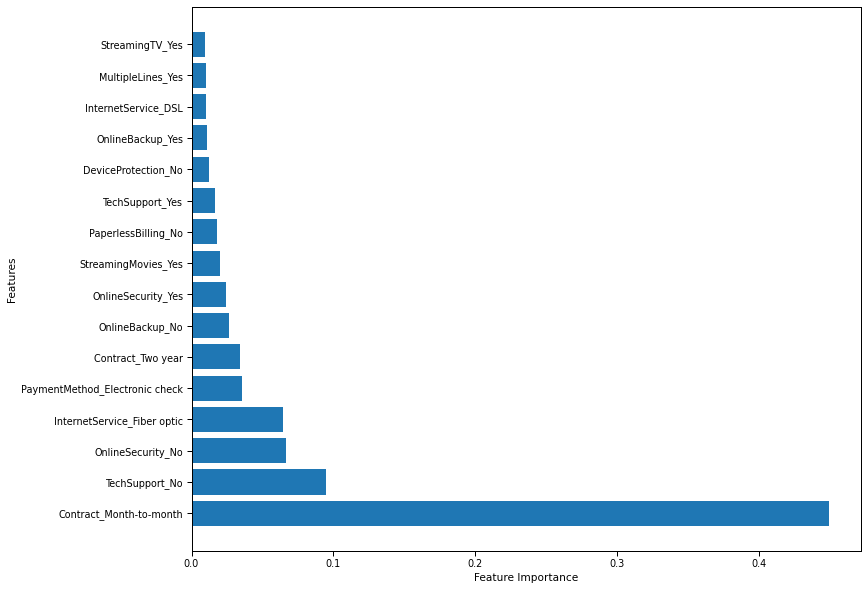

In [37]:
# print the feature importance

xgb_clf = XGBClassifier()
xgb_clf.fit(train_set, y_train)

features = train_set.columns
feature_imp = xgb_clf.feature_importances_

feat_imp_df = pd.DataFrame({'Features' : features, 'Feature_Importance' : feature_imp}).sort_values(by='Feature_Importance', ascending=False)

# Plot the feature_importance : only top 10
plt.figure(figsize=(12,10))
plt.barh(y=feat_imp_df['Features'].iloc[ :16], width=feat_imp_df['Feature_Importance'].iloc[ :16])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

In [38]:
feat_imp_df['Features'][:10].values

array(['Contract_Month-to-month', 'TechSupport_No', 'OnlineSecurity_No',
       'InternetService_Fiber optic', 'PaymentMethod_Electronic check',
       'Contract_Two year', 'OnlineBackup_No', 'OnlineSecurity_Yes',
       'StreamingMovies_Yes', 'PaperlessBilling_No'], dtype=object)

------------
# Data Preprocessing

In [39]:
X_test = X_test.drop(['customerID'], axis=1)
X_train = X_train.drop(['customerID'], axis=1)

In [40]:
X_val = X_val.drop(['customerID'], axis=1)

In [41]:
X_train.select_dtypes('object').columns

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [42]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod']
encoded_features = enc.fit(X_train[cols])
encoded_features = enc.transform(X_train[cols])

s = encoded_features.toarray()
print(s)
ohe_df = pd.DataFrame(s, columns=enc.get_feature_names())
data_train = X_train.drop(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'], axis=1)
data_train = data_train.reset_index()
data_train = data_train.drop(['index'], axis=1)
data_train = data_train.join(ohe_df)
data_train

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 1. 0.]
 [0. 1. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 0. 1.]]


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,x0_Female,x0_Male,x1_No,x1_Yes,x2_No,x2_Yes,x3_No,x3_Yes,x4_No,x4_No phone service,x4_Yes,x5_DSL,x5_Fiber optic,x5_No,x6_No,x6_No internet service,x6_Yes,x7_No,x7_No internet service,x7_Yes,x8_No,x8_No internet service,x8_Yes,x9_No,x9_No internet service,x9_Yes,x10_No,x10_No internet service,x10_Yes,x11_No,x11_No internet service,x11_Yes,x12_Month-to-month,x12_One year,x12_Two year,x13_No,x13_Yes,x14_Bank transfer (automatic),x14_Credit card (automatic),x14_Electronic check,x14_Mailed check
0,0,72,114.55,8306.05,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0,25,20.60,541.50,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0,25,34.00,853.00,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0,2,73.25,131.05,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1,63,36.10,2298.90,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4220,1,56,94.80,5264.30,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4221,0,12,94.20,1046.10,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4222,0,1,44.55,44.55,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4223,0,18,19.00,348.80,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [43]:
print(X_val[X_val['TotalCharges'] == ' '])


      gender  SeniorCitizen Partner  ... PaymentMethod  MonthlyCharges TotalCharges
936   Female              0     Yes  ...  Mailed check           80.85             
753     Male              0      No  ...  Mailed check           20.25             
1082    Male              0     Yes  ...  Mailed check           25.75             
6670  Female              0     Yes  ...  Mailed check           73.35             

[4 rows x 19 columns]


In [44]:
X_val['TotalCharges'] = X_val['TotalCharges'].apply(lambda x: x.strip()).replace('', np.nan)
X_val['TotalCharges'] = X_val['TotalCharges'].fillna(X_val['TotalCharges'].median(), axis=0)

In [45]:
X_val['TotalCharges'] = X_val['TotalCharges'].astype('float64')

In [46]:
final_val_cat = enc.transform(X_val[cols]).toarray()
ohe_df_val = pd.DataFrame(final_val_cat, columns=enc.get_feature_names())
data_val = X_val.drop(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'], axis=1)
data_val = data_val.reset_index()
data_val = data_val.drop(['index'], axis=1)
data_val = data_val.join(ohe_df_val)
data_val

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,x0_Female,x0_Male,x1_No,x1_Yes,x2_No,x2_Yes,x3_No,x3_Yes,x4_No,x4_No phone service,x4_Yes,x5_DSL,x5_Fiber optic,x5_No,x6_No,x6_No internet service,x6_Yes,x7_No,x7_No internet service,x7_Yes,x8_No,x8_No internet service,x8_Yes,x9_No,x9_No internet service,x9_Yes,x10_No,x10_No internet service,x10_Yes,x11_No,x11_No internet service,x11_Yes,x12_Month-to-month,x12_One year,x12_Two year,x13_No,x13_Yes,x14_Bank transfer (automatic),x14_Credit card (automatic),x14_Electronic check,x14_Mailed check
0,0,53,19.75,1052.35,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0,58,82.50,4828.05,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0,42,49.55,2077.95,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0,1,50.35,50.35,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0,1,81.70,81.70,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,0,54,79.85,4308.25,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1405,0,42,20.25,854.90,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1406,0,34,116.25,3899.05,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1407,0,72,105.25,7609.75,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


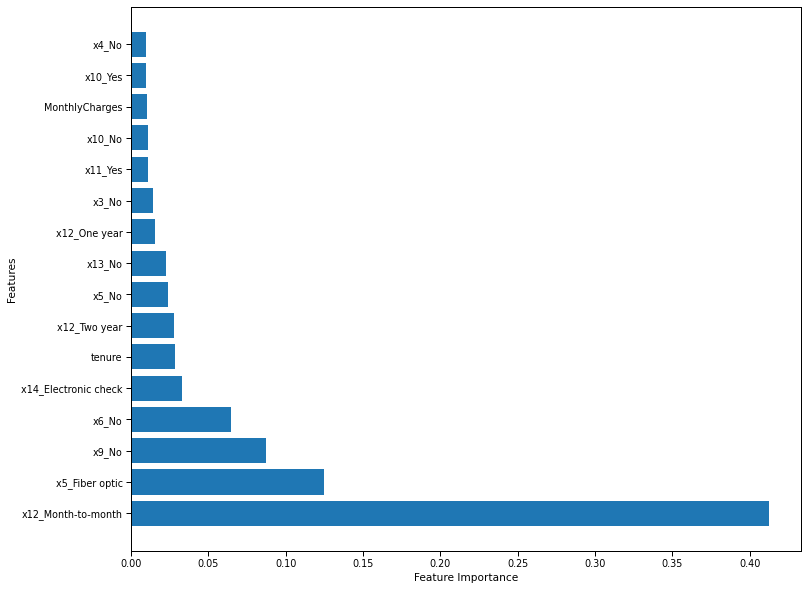

In [47]:
# print the feature importance

xgb_clf = XGBClassifier()
xgb_clf.fit(data_train, y_train)

features = data_train.columns
feature_imp = xgb_clf.feature_importances_

feat_imp_df = pd.DataFrame({'Features' : features, 'Feature_Importance' : feature_imp}).sort_values(by='Feature_Importance', ascending=False)

# Plot the feature_importance : only top 10
plt.figure(figsize=(12,10))
plt.barh(y=feat_imp_df['Features'].iloc[ :16], width=feat_imp_df['Feature_Importance'].iloc[ :16])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

In [48]:
feat_imp_df['Features'][:10].values

array(['x12_Month-to-month', 'x5_Fiber optic', 'x9_No', 'x6_No',
       'x14_Electronic check', 'tenure', 'x12_Two year', 'x5_No',
       'x13_No', 'x12_One year'], dtype=object)

In [49]:
data_train_ = data_train[['x12_Month-to-month', 'x5_Fiber optic', 'x9_No', 'x6_No',
       'x14_Electronic check', 'tenure', 'x12_Two year', 'x5_No',
       'x13_No', 'x12_One year']]
data_val_ = data_val[['x12_Month-to-month', 'x5_Fiber optic', 'x9_No', 'x6_No',
       'x14_Electronic check', 'tenure', 'x12_Two year', 'x5_No',
       'x13_No', 'x12_One year']]

In [50]:
#scaling 
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
final_train_ = ss.fit(data_train_)
final_train_ = ss.transform(data_train_)
final_val_ = ss.transform(data_val_)

In [51]:
#scaling 
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
final_train = ss.fit(data_train)
final_train = ss.transform(data_train)
final_val = ss.transform(data_val)

# Building the model




### Pipeline of Model building, model evaluate and model optimizer (model improvement)

In [52]:
data_train.shape

(4225, 45)

Here we will try to use train and test data that have been feature selection in accordance with the previous important features. **With activation function layers 1 and 2 with ReLU and for output with sigmoid.**

Here we normalize to normalize the data.

In [80]:
# data normalizer
normalizer1 = tf.keras.layers.Normalization(axis=-1)
normalizer1.adapt(final_train_)

## Using adam optimizer

In [81]:
# Define Model's Architecture

def get_uncompiled_model_1():
  model = tf.keras.Sequential([
                               normalizer1,
                               tf.keras.layers.Dense(100, activation='relu'),
                               tf.keras.layers.Dense(300, activation='relu'),
                               tf.keras.layers.Dense(1, activation='sigmoid')              
  ])
  return model


# Define Training Configuration (Optimizer, Loss, Metrics)
def get_compiled_model_1():
    model = get_uncompiled_model_1()
    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    return model

### Earlystopping callbacks

In [86]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 2,
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

In [87]:
# Train Program

## First, let's create a training Dataset instance.
train_dataset_ = tf.data.Dataset.from_tensor_slices((final_train_, y_train))

## Shuffle and slice train dataset.
train_dataset_ = train_dataset_.shuffle(buffer_size=1024).batch(5)

## Now we get a test dataset.
test_dataset_ = tf.data.Dataset.from_tensor_slices((data_test_, y_test))
test_dataset_ = test_dataset_.batch(5)

## Call model to be compiled
model = get_compiled_model_1()

## Since the dataset already takes care of batching, we don't pass a `batch_size` argument.
model.fit(train_dataset_, epochs=50, callbacks=earlystop)

## Evaluate on a dataset.
print("\nEvaluate on test data")
result = model.evaluate(test_dataset_)
print('Test - Loss     : ', result[0])
print('Test - Accuracy : ', result[1])
print('')

Epoch 1/50
845/845 [==============================] - 4s 4ms/step - loss: 0.4324 - accuracy: 0.7893
Epoch 2/50
845/845 [==============================] - 3s 4ms/step - loss: 0.4242 - accuracy: 0.7927
Epoch 3/50
845/845 [==============================] - 3s 4ms/step - loss: 0.4176 - accuracy: 0.7998
Epoch 4/50
845/845 [==============================] - 3s 4ms/step - loss: 0.4171 - accuracy: 0.8024
Epoch 5/50
845/845 [==============================] - 3s 4ms/step - loss: 0.4159 - accuracy: 0.7993
Epoch 6/50
845/845 [==============================] - 3s 4ms/step - loss: 0.4163 - accuracy: 0.7979
Epoch 7/50
845/845 [==============================] - 3s 4ms/step - loss: 0.4124 - accuracy: 0.8028
Epoch 8/50
845/845 [==============================] - 3s 4ms/step - loss: 0.4137 - accuracy: 0.8036
Epoch 9/50
845/845 [==============================] - 3s 4ms/step - loss: 0.4121 - accuracy: 0.8009
Epoch 10/50
845/845 [==============================] - 3s 4ms/step - loss: 0.4116 - accuracy: 0.8033

## Using adamax optimizer

In [88]:
# Define Model's Architecture

def get_uncompiled_model():
  model = tf.keras.Sequential([
                               normalizer1,
                               tf.keras.layers.Dense(100, activation='relu'),
                               tf.keras.layers.Dense(300, activation='relu'),
                               tf.keras.layers.Dense(1, activation='sigmoid')              
  ])
  return model


# Define Training Configuration (Optimizer, Loss, Metrics)
def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="Adamax",
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    return model

In [89]:
# Train Program

## First, let's create a training Dataset instance.
train_dataset_ = tf.data.Dataset.from_tensor_slices((final_train_, y_train))

## Shuffle and slice train dataset.
train_dataset_ = train_dataset_.shuffle(buffer_size=1024).batch(5)

## Now we get a test dataset.
test_dataset_ = tf.data.Dataset.from_tensor_slices((data_test_, y_test))
test_dataset_ = test_dataset_.batch(5)

## Call model to be compiled
model = get_compiled_model()

## Since the dataset already takes care of batching, we don't pass a `batch_size` argument.
model.fit(train_dataset_, epochs=50, callbacks=earlystop)

## Evaluate on a dataset.
print("\nEvaluate on test data")
result = model.evaluate(test_dataset_)
print('Test - Loss     : ', result[0])
print('Test - Accuracy : ', result[1])
print('')

Epoch 1/50
845/845 [==============================] - 4s 4ms/step - loss: 0.4312 - accuracy: 0.7972
Epoch 2/50
845/845 [==============================] - 3s 4ms/step - loss: 0.4201 - accuracy: 0.7974
Epoch 3/50
845/845 [==============================] - 3s 4ms/step - loss: 0.4181 - accuracy: 0.8014
Epoch 4/50
845/845 [==============================] - 3s 4ms/step - loss: 0.4148 - accuracy: 0.7986
Epoch 5/50
845/845 [==============================] - 4s 4ms/step - loss: 0.4146 - accuracy: 0.8012
Epoch 6/50
845/845 [==============================] - 3s 4ms/step - loss: 0.4130 - accuracy: 0.8012
Epoch 7/50
845/845 [==============================] - 3s 4ms/step - loss: 0.4125 - accuracy: 0.8005
Epoch 8/50
845/845 [==============================] - 3s 4ms/step - loss: 0.4110 - accuracy: 0.7993
Epoch 9/50
845/845 [==============================] - 3s 4ms/step - loss: 0.4104 - accuracy: 0.7988
Epoch 10/50
845/845 [==============================] - 3s 4ms/step - loss: 0.4103 - accuracy: 0.7998

In [65]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 10)               21        
 ion)                                                            
                                                                 
 dense_9 (Dense)             (None, 100)               1100      
                                                                 
 dense_10 (Dense)            (None, 300)               30300     
                                                                 
 dense_11 (Dense)            (None, 1)                 301       
                                                                 
Total params: 31,722
Trainable params: 31,701
Non-trainable params: 21
_________________________________________________________________


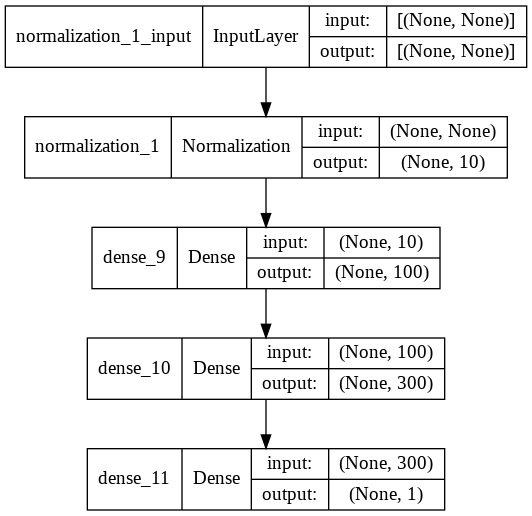

In [66]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Check How Many Batch Groups

print('Number of Batch - Train : ', tf.data.experimental.cardinality(train_dataset).numpy())
print('Number of Batch - Test  : ', tf.data.experimental.cardinality(test_dataset).numpy())

Number of Batch - Train :  423
Number of Batch - Test  :  141


### Validation

In [90]:
# Train ANN with Validation Data

## Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((final_train_, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(5)

## Call model to be compiled
model = get_compiled_model_2()

## Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((final_val_, y_val))
val_dataset = val_dataset.batch(5)

## Train with validation data
model.fit(train_dataset, epochs=50, validation_data=val_dataset)

## Evaluate on a dataset.
print("\nEvaluate on test data")
result = model.evaluate(val_dataset)
print('Test - Loss     : ', result[0])
print('Test - Accuracy : ', result[1])
print('')

Epoch 1/50
845/845 [==============================] - 5s 5ms/step - loss: 0.4339 - accuracy: 0.7865 - val_loss: 0.4222 - val_accuracy: 0.8155
Epoch 2/50
845/845 [==============================] - 4s 5ms/step - loss: 0.4242 - accuracy: 0.7964 - val_loss: 0.4267 - val_accuracy: 0.8098
Epoch 3/50
845/845 [==============================] - 4s 5ms/step - loss: 0.4210 - accuracy: 0.7950 - val_loss: 0.4164 - val_accuracy: 0.8155
Epoch 4/50
845/845 [==============================] - 4s 5ms/step - loss: 0.4199 - accuracy: 0.7979 - val_loss: 0.4246 - val_accuracy: 0.8119
Epoch 5/50
845/845 [==============================] - 4s 5ms/step - loss: 0.4170 - accuracy: 0.7998 - val_loss: 0.4308 - val_accuracy: 0.8247
Epoch 6/50
845/845 [==============================] - 4s 5ms/step - loss: 0.4169 - accuracy: 0.7972 - val_loss: 0.4296 - val_accuracy: 0.8211
Epoch 7/50
845/845 [==============================] - 4s 5ms/step - loss: 0.4158 - accuracy: 0.8026 - val_loss: 0.4306 - val_accuracy: 0.8219
Epoch 

In [67]:
history = model.fit(final_train_, y_train, epochs=100,
                    validation_data=(final_val_, y_val),verbose=0)

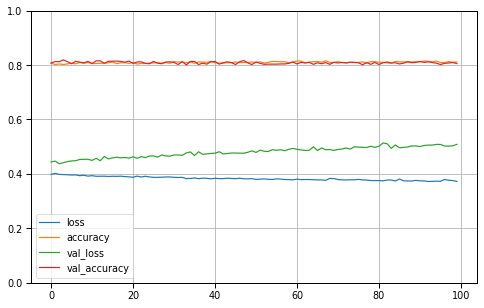

In [68]:
# Create plot of history model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Model inference

In [57]:
# Convert TotalCharges into float type
X_test['TotalCharges'] = X_test['TotalCharges'].apply(lambda x: x.strip()).replace('', np.nan)
X_test['TotalCharges'] = X_test['TotalCharges'].fillna(X_test['TotalCharges'].median(), axis=0)
X_test['TotalCharges'] = X_test['TotalCharges'].astype('float64')


In [58]:

# Apply transform to data test
final_test_cat = enc.transform(X_test[cols]).toarray()
ohe_df_test = pd.DataFrame(final_test_cat, columns=enc.get_feature_names())
data_test = X_test.drop(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'], axis=1)
data_test = data_test.reset_index()
data_test = data_test.drop(['index'], axis=1)
data_test = data_test.join(ohe_df_val)
data_tests = np.array(data_test)

In [69]:
#Apply data_test into transform one hot encode
data_test_ = data_test[['x12_Month-to-month', 'x5_Fiber optic', 'x9_No', 'x6_No',
       'x14_Electronic check', 'tenure', 'x12_Two year', 'x5_No',
       'x13_No', 'x12_One year']]
data_test_ = np.array(data_test_)


# Predict
y_pred_model1 = model.predict(data_test_)
y_pred_model1

array([[0.0000e+00],
       [4.2278e-04],
       [4.4123e-01],
       ...,
       [1.0092e-19],
       [2.2758e-09],
       [0.0000e+00]], dtype=float32)

In [71]:
## Prepare the validation dataset
test_set = tf.data.Dataset.from_tensor_slices((data_test_, y_test))
test_set = test_set.batch(64)

## Evaluate on a dataset.
print("\nEvaluate on test data")
result = model.evaluate(test_set)
print('Test - Loss     : ', result[0])
print('Test - Accuracy : ', result[1])
print('')


Evaluate on test data
23/23 [==============================] - 0s 3ms/step - loss: 14.0917 - accuracy: 0.7339
Test - Loss     :  14.091690063476562
Test - Accuracy :  0.733853816986084



# Model Save

In [104]:
model.save("my_milestone1_model.h5")

# EDA Analysis

1. Telco dataset it doesn't contain any missing values. But in Total charges column contains a few of whitespaces.

2. Currently 16.3% of Telco's customers are old customers who have subscribed while 83.7% are new customers.

3. Distribution of contracts made by customers to Telco is mostly in the month-to-month type, while the least is in the one year type.

4. The payment method that is widely used by customers is Bank Transfer and at least Electronic Check.
The distribution of the bank transfer method is 33.4% while the Electronic Check is 21.5%.

5. Customers with higher Monthly Charges are also more likely to churn.

# Model Analysis

1. The model uses adam and adamax optimizer, and the best result is adam optimizer.

2. Accuracy test and loss on the model, namely

    Test - Loss : 11.30219841003418

    Test - Accuracy : 0.7324343323707581

3. Validation test and loss accuracy

    Test - Loss     :  0.5017935037612915

    Test - Accuracy :  0.8062455654144287

4. The results of accuracy validation and the model are not far off so that it can be said that the model can represent the data well.

5. The model is very flat so the increase is not significant enough as seen from the test and loss accuracy. So it needs to be improved by handling the target data offset.